In [2]:
import pandapower as pp

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import mosek

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [3]:
import os
folder = os.path.abspath(os.getcwd())

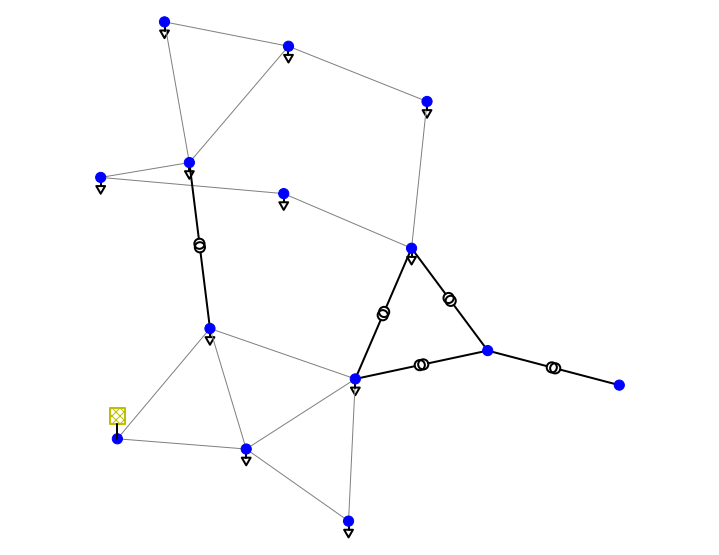

In [4]:
case = "case14"
net, n, gen_df, n_gen, gens, load_df, graph, G_val, B_val, Y_val = load_pp_network(case)

## Variables & parameters

In [5]:
X = cp.Variable((n,n), hermitian=True)

In [6]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [7]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [8]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [9]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y_val
    Phi_i = 1 / 2 * (Y_i.conj().T + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.conj().T - Y_i)
    Psis.append(Psi_i)

### Build sparsity graph

In [10]:
sparsity_graph = nx.Graph()
graph_nodes_list = sorted(graph.nodes())
# the sparsity graph of complex variables is exactly the power network
sparsity_graph.add_nodes_from(graph_nodes_list)
sparsity_graph.add_edges_from(graph.edges())

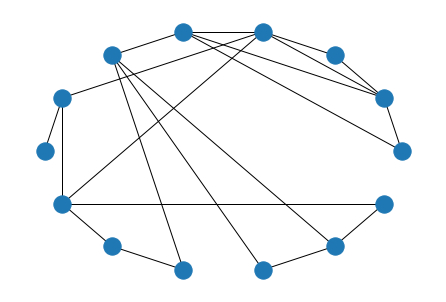

In [11]:
nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

## TODO: edge elimination

In [12]:
# edge_elimination_list = list(sparsity_graph.edges)
# sparsity_graph.remove_edges_from(edge_elimination_list)

In [13]:
# for e in edge_elimination_list:
#     sparsity_graph.add_node((e,1))
#     sparsity_graph.add_node((e,2))
#
# sparsity_graph.add_node("one")
#
# for e in edge_elimination_list:
#     sparsity_graph.add_edge((e,1), "one")
#     sparsity_graph.add_edge((e,2), "one")
#     sparsity_graph.add_edge(e[0], "one")
#     sparsity_graph.add_edge(e[1], "one")

In [14]:
# nx.set_edge_attributes(sparsity_graph, 0, "weight")
# n_sparse = sparsity_graph.number_of_nodes()
#
# for i in range(n):
#     Phi_i = Phis[i].value
#     graph_phi_i = sparsity_graph.copy()
#     graph_phi_i.add_edge(i, i, weight=Phi_i[i][i])
#
#     Psi_i = Psis[i].value
#     graph_psi_i = sparsity_graph.copy()
#     graph_psi_i.add_edge(i, i, weight=Psi_i[i][i])
#
#     for j in graph.neighbors(i):  # quadratic terms only appear for adjacent buses
#         if (i,j) in edge_elimination_list:
#             # replace variables in the constraints of bus i
#             graph_phi_i.edges[(((i, j), 1), ((i, j), 1))]["weight"] = Phi_i[i][j]
#             graph_phi_i.edges[(((i, j), 2), ((i, j), 2))]["weight"] = -Phi_i[i][j]
#
#             # TODO: graph_psi_i
#
#             # impose linear constraints on the new variables
#             linear_constraint_mat = np.zeros(n_sparse)
#             # TODO
#
#
#         else:
#             # don't replace variables in the constraints of bus i
#             graph_phi_i.edges[(i, j)]["weight"] = G_val[i][j]
#             graph_phi_i.edges[(n + i, n + j)]["weight"] = G_val[i][j]
#             graph_phi_i.edges[(i, n + j)]["weight"] = -B_val[i][j]
#             graph_phi_i.edges[(n + i, j)]["weight"] = B_val[i][j]
#
#             # TODO

### Construct enriched supergraph

In [15]:
G_bar = build_enriched_supergraph(sparsity_graph)

Treewidth: 2


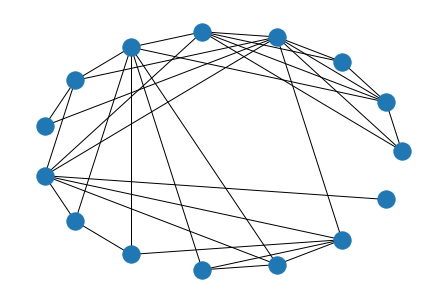

In [16]:
nx.draw(G_bar, nx.circular_layout(G_bar))

## SDP (QCQP)

In [17]:
constraints = [ X >> 0 ]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = gens.index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [18]:
# the power generation costs are not dpp but can be modified
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [19]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [20]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# X.value = sfm.load_solution()[1]
# X_ref_val = X.value

In [21]:
# prob.solve(solver=cp.SCS, verbose=True)
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 12:49:52 PM: Your problem has 196 variables, 41 constraints, and 106 parameters.
(CVXPY) Jul 11 12:49:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 12:49:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 12:49:52 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 11 12:49:52 PM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jul 11 12:49:52 PM: Applying reduction EvalParams
(CVXPY) Jul 11 12:49:52 PM: Appl

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


(CVXPY) Jul 11 12:49:52 PM: 3   2.9e+01  8.2e-01  9.1e-01  -7.95e-01  -4.618884032e+03  -4.663385341e+03  1.1e-02  0.04  
(CVXPY) Jul 11 12:49:52 PM: 4   6.4e+00  1.9e-01  2.0e-01  -3.30e-01  -4.931193144e+03  -4.975247876e+03  2.6e-03  0.05  
(CVXPY) Jul 11 12:49:52 PM: 5   1.3e+00  3.8e-02  2.4e-02  4.80e-01   -4.736698532e+03  -4.751792986e+03  5.3e-04  0.05  
(CVXPY) Jul 11 12:49:52 PM: 6   3.0e-01  8.7e-03  6.2e-03  3.23e-01   -4.422555105e+03  -4.443399278e+03  1.2e-04  0.06  
(CVXPY) Jul 11 12:49:52 PM: 7   8.3e-02  2.4e-03  2.7e-03  -6.59e-01  -3.138565101e+03  -3.193250399e+03  3.3e-05  0.07  
(CVXPY) Jul 11 12:49:52 PM: 8   3.1e-02  8.9e-04  9.3e-04  -3.16e-01  -1.137336553e+03  -1.183180802e+03  1.2e-05  0.07  
(CVXPY) Jul 11 12:49:52 PM: 9   5.0e-03  1.4e-04  1.1e-04  8.97e-02   2.004092539e+03   1.981529216e+03   2.0e-06  0.08  
(CVXPY) Jul 11 12:49:52 PM: 10  7.5e-04  2.1e-05  6.0e-06  6.88e-01   3.185757394e+03   3.182423627e+03   3.0e-07  0.09  
(CVXPY) Jul 11 12:49:52 

8079.950945019173

In [22]:
np.linalg.eigvalsh(X.value)

array([-1.84102437e-10, -1.73817315e-10, -1.71931213e-10, -1.68544413e-10,
       -1.59710442e-10, -1.41192882e-10, -1.30789844e-10, -8.22289796e-11,
       -5.07094564e-11,  1.04787473e-10,  1.97694259e-07,  6.68028996e-07,
        2.41378364e-03,  1.47606805e+01])

In [23]:
X_val = X.value

In [24]:
recover_verify_solution(prob, X, 1)

1.6228845945973124e-15
[0.]
[0.]
[0.]
[4.89243597e-08]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00090539]
[0.00312549]
[1.5572106e-06]
[0.00153923]
[0.]
[0.]
[0.]
[0.]
[0.00021512]
[0.00461333]
[0.]
[0.]
[0.]
[0.]
[0.00089161]
[4.44115124e-05]
[5.14881593e-06]
[3.46538404e-06]
[1.94363795e-06]
[1.08491809e-06]
[3.65189002e-06]
[9.02881721e-07]
[7.80295443e-06]
[3.40890112e-06]
[8.71665903e-06]
[2.95957331e-06]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Interior point computation

In [25]:
prob_center = cp.Problem(cp.Maximize( cp.log_det(X)
                                      + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[gens[i]] @ X)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ])
                                      + cp.sum([cp.log(q_max[i] - cp.real(cp.trace(Psis[gens[i]] @ X)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ])
                                      + cp.sum([ cp.log(V_max_sq[i] - cp.real(X[i][i])) + cp.log(cp.real(X[i][i]) - V_min_sq[i]) for i in range(n) ]) ), constraints)

# prob_center.solve(solver=cp.SCS, verbose=True)
prob_center.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 12:49:52 PM: Your problem has 196 variables, 41 constraints, and 76 parameters.
(CVXPY) Jul 11 12:49:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 12:49:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 12:49:52 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 11 12:49:52 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jul 11 12:49:52 PM: Applying reduction Complex2Real
(CVXPY) Jul 11 12:49:52 PM: 

-157.23400563739384

In [26]:
X_center = X.value

### Fixed point iterations

In [27]:
X.value = X_val
fixed_point_iteration(prob, X, -X_center, True)

initial objective: 8079.950945
initial eigenvalues:
[-1.84102437e-10 -1.73817315e-10 -1.71931213e-10 -1.68544413e-10
 -1.59710442e-10 -1.41192882e-10 -1.30789844e-10 -8.22289796e-11
 -5.07094564e-11  1.04787473e-10  1.97694259e-07  6.68028996e-07
  2.41378364e-03  1.47606805e+01]
current objective: 9519.269143
current objective: 9568.546917
current objective: 9573.462746
fixed point objective: 9573.882731
fixed point eigenvalues:
[-1.65945353e-10 -1.62792218e-10 -1.52217913e-10 -1.42714425e-10
 -1.26740272e-10 -1.14489222e-10 -1.05328166e-10 -6.07026126e-11
  7.19852319e-11  4.18699943e-10  7.73027394e-10  1.77746483e-09
  2.24411645e-02  1.51743510e+01]
iterations:  4


array(None, dtype=object)

In [28]:
recover_verify_solution(prob, X, 1)

2.83656987713632e-15
[0.]
[0.]
[0.]
[0.47956217]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00293945]
[0.]
[0.00081401]
[0.00209692]
[0.00237495]
[0.00183854]
[0.]
[0.00011392]
[0.]
[0.]
[8.62068728e-05]
[8.1533721e-05]
[0.]
[0.0002298]
[0.]
[0.]
[0.00011145]
[5.11514965e-06]
[3.30559108e-05]
[3.67370553e-05]
[3.0880728e-05]
[2.70946185e-05]
[2.49382693e-05]
[2.26131803e-05]
[2.74994283e-05]
[2.38618885e-05]
[2.08857974e-05]
[2.83420938e-05]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Low-rank SDP

In [29]:
n_bar = G_bar.number_of_nodes()
X_bar = cp.Variable((n_bar, n_bar), hermitian=True)
X_ref = cp.Parameter((n, n), hermitian=True, value=X_val)
Z = cp.Parameter((n_bar, n_bar), symmetric=True, value=nx.to_numpy_array(G_bar))

low_rank_constraints = [ X_bar >> 0 ]
low_rank_constraints += [ X_bar[k][k] == X_ref[k][k] for k in sparsity_graph.nodes ]
low_rank_constraints += [ X_bar[k][k] == 1 for k in set(G_bar.nodes).difference(set(sparsity_graph.nodes)) ]
low_rank_constraints += [ X_bar[i][j] == X_ref[i][j] for (i,j) in sparsity_graph.edges ]

low_rank_prob = cp.Problem(cp.Minimize(cp.real(cp.trace(Z @ X_bar))), low_rank_constraints)

In [30]:
# X_bar.value = np.block([
#     [X_ref_val, np.zeros((n, n_bar - n))],
#     [np.zeros((n_bar - n, n)), np.eye(n_bar-n)]
# ])
#
# for c in low_rank_prob.constraints:
#     print(c.violation())

In [31]:
# low_rank_prob.solve(solver=cp.SCS, verbose=True)
low_rank_prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 12:49:54 PM: Your problem has 225 variables, 36 constraints, and 421 parameters.
(CVXPY) Jul 11 12:49:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 12:49:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 12:49:54 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 11 12:49:54 PM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jul 11 12:49:54 PM: Applying reduction EvalParams
(CVXPY) Jul 11 12:49:54 PM: Appl

62.956200140930626

In [32]:
X.value = X_bar.value[0:n, 0:n]
print(np.linalg.eigvalsh(X.value))
print(prob.objective.value)

[-2.50108266e-09 -2.10382747e-09 -1.66347980e-09 -1.09843513e-09
 -6.66709512e-10  4.58938845e-11  3.03963119e-10  2.34470378e-09
  2.79312623e-09  4.52761647e-09  8.90519728e-09  5.69980751e-07
  2.44741937e-03  1.47606471e+01]
8079.951028318502


In [33]:
for c in prob.constraints:
    print(c.violation())

2.0975829203147462e-09
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.89532881e-08]
[3.94362957e-08]
[2.95630979e-09]
[2.68279567e-08]
[0.]
[0.]
[0.]
[0.]
[1.93509875e-10]
[1.10711227e-08]
[0.]
[0.]
[0.]
[0.]
[8.34493047e-09]
[2.61254514e-08]
[4.50835294e-09]
[1.22030028e-08]
[3.0946051e-09]
[6.56772346e-09]
[2.63087491e-09]
[3.21755843e-09]
[9.86299165e-09]
[1.63255828e-08]
[5.07605555e-09]
[9.18068839e-09]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
recover_verify_solution(prob, X, 1)

2.717236935042142e-15
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00092832]
[0.0031187]
[1.80853153e-05]
[0.0015432]
[0.]
[0.]
[0.]
[0.]
[0.0002334]
[0.00453559]
[0.]
[0.]
[0.]
[0.]
[0.00088437]
[4.4684519e-05]
[2.98626986e-06]
[3.29212275e-06]
[1.25429364e-06]
[8.34881632e-07]
[3.9481282e-06]
[9.85064821e-07]
[8.68305278e-06]
[1.6999585e-07]
[7.44071812e-06]
[2.40183138e-07]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Low-rank SDP - fixed point iteration

In [35]:
fixed_point_iteration(prob, X, -X_center, True)

initial objective: 8079.951028
initial eigenvalues:
[-2.50108266e-09 -2.10382747e-09 -1.66347980e-09 -1.09843513e-09
 -6.66709512e-10  4.58938845e-11  3.03963119e-10  2.34470378e-09
  2.79312623e-09  4.52761647e-09  8.90519728e-09  5.69980751e-07
  2.44741937e-03  1.47606471e+01]
current objective: 9519.264944
current objective: 9568.546440
current objective: 9573.462706
fixed point objective: 9573.882728
fixed point eigenvalues:
[-1.66001641e-10 -1.62842951e-10 -1.52307383e-10 -1.42804731e-10
 -1.26850638e-10 -1.14654845e-10 -1.05515733e-10 -6.09470217e-11
  7.16334640e-11  4.18481179e-10  7.72862741e-10  1.77740476e-09
  2.24411646e-02  1.51743510e+01]
iterations:  4


array(None, dtype=object)

In [36]:
recover_verify_solution(prob, X, 2)

1.6468757184950422e-15
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.67615988e-09]
[3.45275245e-09]
[6.85838747e-11]
[2.57444553e-09]
[0.]
[0.]
[1.47289653e-09]
[0.]
[5.97312755e-11]
[2.63789968e-09]
[0.]
[0.]
[0.]
[0.]
[9.055518e-10]
[3.70127892e-09]
[7.77610115e-10]
[2.1669761e-09]
[3.9038181e-10]
[1.27662701e-09]
[4.013328e-10]
[4.09614551e-10]
[8.93246699e-10]
[1.39264905e-09]
[3.3587863e-10]
[6.2977952e-10]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Hyperplane rounding

In [37]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [38]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

7678.822382004334


/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  p_g[i] = p_d[i][0] + G[i][i] * X[i][i] + np.sum(
/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  q_g[i] = q_d[i][0] - B[i][i] * X[i][i] + np.sum(


In [39]:
check_power_feasibility(np.outer(hyperplane_v, hyperplane_v.conj()), p_min.value, p_max.value, q_min.value, q_max.value, gens, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

reactive power generation 0 is too low: q_g = -0.341326 < 0.000000


In [40]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X.value, None, None)